In [1]:
import numpy as np
import MDSplus as mds
from  scipy.linalg import eigh, solve_banded

In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib widget

In [4]:
r_end = 0.93
sys_err = 5

In [5]:
### load the data
bright = np.loadtxt('/home/sthoma/inversion-tools/Example/shot_1070511010_brightness_data.txt')
### say which channels are good based off zeros
good_chans = np.where(bright[0] != 0)[0]
### load R
R = np.loadtxt('/home/sthoma/inversion-tools/Example/shot_1070511010_R_values.txt')
lfs_r = R[good_chans]
### flip R
lfs_r = np.flip(lfs_r)

### adds some higher R value
if r_end:
    lfs_r = np.insert(lfs_r,len(lfs_r),r_end)
### number of R values
nch_lfs = len(lfs_r)

### this is for calibration! and for the error on the calibration. 
calf = np.ones(lfs_r.shape)
calfErr = np.ones(lfs_r.shape)*sys_err/100

### creating the response matrix
R_tg_virtual = lfs_r
#center of mass of the LOS, assume z=0
R_tg = R_tg_virtual
Z_tg = np.zeros_like(R_tg) 
### upper and lower R values
lfs_min = R_tg[0]
lfs_max = R_tg[-1]
### gives resolution of emissivity grid, and makes Rgrid
nr = 50 
R_grid = np.linspace(lfs_min, lfs_max, nr)

### returns a 2D array with dimensions of the grid and the original viewing
### locations. It's the different between the R location of the two.
### if any of them it is negative, it replaces it with a zero
### then it does it again but with only 1 space difference, and then it does
### the difference between them and multiplies it by 2?
dL = 2*(np.sqrt(np.maximum((R_grid[1:])**2-R_tg_virtual[:,None]**2,0))
       -np.sqrt(np.maximum( R_grid[:-1]**2-R_tg_virtual[:,None]**2,0)))
# dL = dL # no need to sum over spot size
print('end of load_geometry')

end of load_geometry


In [6]:
# plt.figure(figsize=(3.35,2.5), dpi=150)
# plt.plot(R)
# plt.figure(figsize=(3.35,2.5), dpi=150)
# plt.plot(lfs_r)
# plt.figure(figsize=(3.35,2.5), dpi=150)
# plt.plot(R_tg_virtual)
# plt.figure(figsize=(3.35,2.5), dpi=150)
# plt.plot(R_tg)
# plt.figure(figsize=(3.35,2.5), dpi=150)
# plt.plot(Z_tg)
# plt.figure(figsize=(3.35,2.5), dpi=150)
# plt.plot(R_grid)
# plt.figure(figsize=(3.35,2.5), dpi=150)
# plt.plot(dL)

In [7]:
#### load the data, good channels only, and flip it to match the flipped R
raw_data = np.loadtxt('/home/sthoma/inversion-tools/Example/shot_1070511010_brightness_data.txt')
raw_data = raw_data[:,good_chans]
raw_data = np.flip(raw_data, axis=1)
### add a zero at desired r_end value
if r_end:
    _zeros = np.zeros(len(raw_data[:,0]))[:,None]
    raw_data = np.concatenate((raw_data,_zeros),axis=1)
### number of views
n_los = len(raw_data[0])
### load the time 
tvec = np.loadtxt('/home/sthoma/inversion-tools/Example/shot_1070511010_t_values.txt')


### assume the first index is last good one
last_good_ind = 0
count = 0
### iterate over the time
for tt in range(len(tvec)):
    ### always select the highest R value that isn't one we appended 
    min_data = raw_data[tt,-2] # because there's a 0 by default at the end
    ### if this point is positive, make this the last good time index
    if min_data >= 0:
        last_good_ind = tt
#         print('tt={}, >0, last_good_ind={}, '.format(tt, last_good_ind))

    ### if this point is negative, I want to add on the maximum value from the 
    ### last good time index to all the points in this current one?
    
    ### I don't really understand why though
    
    elif min_data < 0:
        count += 1
#         plt.figure()
#         plt.plot(lfs_r, raw_data[tt])
        raw_data[tt,:-1] += np.max(raw_data[last_good_ind])
#         print('tt={}, <0, adding {}'.format(tt, np.max(raw_data[last_good_ind])))
#         plt.plot(lfs_r, raw_data[tt], '--')
#         plt.title('tt={}, count={}'.format(tt, count))
#         plt.grid()

In [8]:
### the index slice that goes before t=0
offset = slice(0, tvec.searchsorted(0))
### sampling time
dt = (tvec[-1]-tvec[0])/(len(tvec)-1)
### smooth is not done here, hence = 1
n_smooth = 1
### data shapes
nt, nch = raw_data.shape
### copy of the data and time
data_low = raw_data
tvec_low = tvec
### adjust nt if need be
nt = nt//n_smooth*n_smooth
### I don't really know what this is doing
tvec_low = tvec[:nt].reshape(-1,n_smooth).mean(1)
### nor do I know what this is really doing,
### but it is removing an offset
data_low = raw_data[:nt].reshape(-1,n_smooth, nch).mean(1)-raw_data[offset].mean(0)

### these three aren't used
# error_low1 = np.zeros_like(data_low)
# error_low2 = np.std(data_low[tvec_low<0],0)
# error_low21 = np.std(data_low[tvec_low<0],0)[None,:]
### estimate noise from the signal before the plasma
error_low = np.zeros_like(data_low)+np.std(data_low[tvec_low<0],0)[None,:]/3


### guess errorbarss from the variation between neighboring channels
ind1 = np.r_[1,0:n_los-1]
ind2 = np.r_[  1:n_los  ,n_los-2]
# the ind1 and ind2, basically shift data_low up and down by one to find the average
# value of the neighboring channels. That is then subtracting from the original array
# to get the average difference from neighboring hcannels

# the difference between the followin neighbor is calculated and then the standard error
# is calculated for each channel
error_low += np.std(np.diff(data_low-(data_low[:,ind1]+data_low[:,ind2])/2,axis=0),axis=0)/np.sqrt(2)

# remove offset estimated from the edge most detector
offset_time = data_low[:,[-1]]
data_low -= offset_time
# make sure that zero value is within errorbars when data are negative
error_low = np.maximum(error_low, -data_low)

### this converts the data to the calibrated data
data = data_low * calf#[ph/m^2s]
err  = np.sqrt(\
            (error_low*calf)**2+\
            (data_low*calfErr)**2
           ) #[ph/m^2s] # laggnerf
tvec = tvec_low #[s]
scale = np.median(data) #just a normalisation to aviod calculation with so huge exponents

nt = len(tvec)
print('end of load_data')

end of load_data


In [9]:
n_blocks = len(tvec)

In [10]:
### no idea what these are, they're just there

# defined independently for LFS and HFS
reg_level_guess = .7, .6
reg_level_min = .4, .4

nfisher = 4

iside = 0
lfs_contribution = [0]

In [11]:
### biased_edges is used as True
def regul_matrix(biased_edges=True):
    #regularization band matrix
    bias = .1 if biased_edges else 1e-5
    ### (3 x R_grid-1), all 1s
    D = np.ones((3,nr-1))
    ### make row 1 all negative 2s
    D[1,:] *= -2
    ### last in middle row is bias value
    D[1,-1] = bias
    ### middle row, first element and second last element are negative 1s
    D[1,[0,nr-3]] = -1
    ### last row, elements -2 and -3 are set to zero
    D[2,[-2,-3]] = 0
    return D

In [12]:
def GCV(g, prod, S, U):
    #generalized crossvalidation
    w = 1. / (1. + np.exp(g) / S**2)
    ndets = len(prod)
    return (np.sum((((w - 1) * prod))**2) + 1) / ndets / (1 - np.mean(w))**2

In [13]:
def FindMin(F, x0, dx0, prod, S, U, tol=0.01):
    #stupid but robust minimum searching algorithm.
    fg = F(x0, prod, S, U)
    while abs(dx0) > tol:
        fg2 = F(x0 + dx0, prod, S, U)
        if fg2 < fg:
            fg = fg2
            x0 += dx0
            continue
        else:
            dx0 /= -2.

    return x0, np.log(fg2)

In [14]:
D = regul_matrix(biased_edges=True)
### a bunch of empty arrays
### len(time) x len(R_grid)-1
y = np.zeros((nt, nr-1))
print(y.shape)
y_err = np.zeros((nt, nr-1))

### len(time)
chi2lfs = np.zeros(nt)
gamma_lfs = np.zeros(nt)

### shape of data
backprojection = np.zeros_like(data)

### indices for time
itime = np.arange(nt)
### splits the time indices up into the number of blocks
### but it is normally just length of time for n_blocks
tinds = np.array_split(itime, n_blocks)

for ib, tind in enumerate(tinds):
#     print('ib={}, tind={}'.format(ib,tind))
    ### where the mean of the error, and the error, are zero
    ### averaging across time
    mean_err_zero_inds = np.where(err[tind].mean(0) == 0)
    err_zero_inds = np.where(err[tind] == 0)
    
    ### no idea what T is, it's this dL thing divided by error
    ### and then multiplied by scale
    T = dL / err[tind].mean(0)[:,None] * scale
    ### mean of the data in this time divided by the mean of the error
    mean_d = data[tind].mean(0) / err[tind].mean(0)
    ### data divided by error
    d = data[tind] / err[tind]
    
    ### replace infinities and nans with 0
    T[mean_err_zero_inds] = 0
    mean_d[mean_err_zero_inds] = 0
    d[err_zero_inds] = 0
    
    ### load of ones for now
    W = np.ones(nr-1)
    ### some slices, zero uptp # channels, and the # R_grid
    ind_los = slice(0,nch_lfs)
    ind_space = slice(0,nr-1)
    
    ### makes Q the same length as the ind_los slice
    Q = np.linspace(0, 1, ind_los.stop - ind_los.start)
    
    
    
    for ifisher in range(nfisher):
#         print('ifisher={}'.format(ifisher))
        
        ### multiply tridiagonal regularisation operator by a diagonal weight matrix W
        WD = np.copy(D)

        ### seems redundent, as W is all ones
        WD[0,1:]*=W[:-1]
        WD[1]*=W
        WD[2,:-1]*=W[1:]
        
        ### transpose the band matrix
        DTW = np.copy(WD)
        DTW[0,1:],DTW[2,:-1] = WD[2,:-1],WD[0,1:]
        
        
        #####    solve Tikhonov regularization (optimised for speed)
        ### this is from scipy, and is solving a banded matrix?
        H = solve_banded((1,1), DTW, T[ind_los,ind_space].T, overwrite_ab=True, check_finite=False)
        #fast method to calculate U,S,V = svd(H.T) of rectangular matrix
        LL = np.dot(H.T, H)
        #### also from scipy
        S2, U = eigh(LL, overwrite_a=True, check_finite=False, lower=True)
        S2 = np.maximum(S2, 1) #singular values S can be negative due to numerical uncertainty
        
        mean_p = np.dot(mean_d[ind_los] - np.mean(lfs_contribution, 0), U)
        
        #guess for regularisation - estimate quantile of log(S^2)
        g0 = np.interp(reg_level_guess[iside], Q, np.log(S2))
        
        if ifisher == nfisher -1:
            #last step - find optimal regularisation
            S = np.sqrt(S2)

            g0, log_fg2 = FindMin(GCV, g0 , 1, mean_p, S, U.T) #slowest step
            #avoid too small regularisation when min of GCV is not found

            gmin = np.interp(reg_level_min[iside], Q, np.log(S2))
            g0 = max(g0, gmin)

            #filtering factor
            w = 1. / (1. + np.exp(g0) / S2)

            V = np.dot(H, U / S)
            V = solve_banded((1,1), WD, V, overwrite_ab=True, overwrite_b=True, check_finite=False)
        else:
            #filtering factor
            w = 1. / (1. + np.exp(g0) / S2)

            #calculate y without evaluating V explicitly
            Y = np.dot(H, np.dot(U / S2, w * mean_p))
            #final inversion of mean solution , reconstruction
            Y = solve_banded((1,1), WD, Y, overwrite_ab=True, overwrite_b=True, check_finite=False)

            #weight matrix for the next iteration
            W = 1 / np.maximum(Y, 1e-10)**.5
            
    p = np.dot(d[:,ind_los] - lfs_contribution, U)
    Y = np.dot((w/S) * p, V.T)

    backprojection[tind,ind_los] = fit = np.dot(p*w, U.T) + lfs_contribution
    chi2 = np.sum((d[:,ind_los] - fit)**2, 1) / np.size(fit, 1)
    gamma = np.interp(g0, np.log(S2), Q)

    chi2lfs[tind] = chi2
    gamma_lfs[tind] = gamma

    y[tind,ind_space] = Y
    #correction for under/over estimated data uncertainty
    y_err[tind,ind_space] = np.sqrt(np.dot(V**2, (w / S)**2))#*chi2[:,None])
    
backprojection[tind] *= err[tind].mean(0)

y *= scale
y_err *= scale

R_grid_b = (R_grid[1:]+ R_grid[:-1])/2

(547, 49)


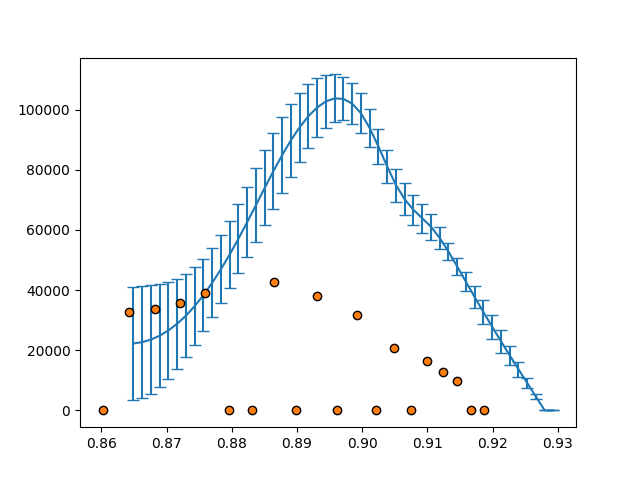

In [26]:
plt.figure()
plt.errorbar(R_grid_b, y[300], yerr=y_err[300], fmt='-', c='C0', capsize=4, zorder=1)
plt.plot(R, bright[300], 'o', c='C1', mec='k')
# plt.plot(R[good_chans][::-1], backprojection[300,:-1]/backprojection[300,:-1].max()*bright[300].max(), c='C2')